# Preparation

In this example, we prepare training/validation data for melody/vocal separation task.

Before running bunch of codes below, please download `DSD100` dataset from
[the DSD100 download page](https://sigsep.github.io/datasets/dsd100.html)
and say it `DSD100.zip`.

### Initializing `AudioMixer`

In [1]:
from chimeranet.audio_mixer import AudioMixer
from chimeranet.dataset_loader.dsd100\
    import DSD100MelodyLoader, DSD100VocalLoader

dsd_path = 'DSD100.zip'
am = AudioMixer()
am.add_loader(
    DSD100MelodyLoader(dsd_path),
    a_time = (-0.01, 0.01), # data augmentation on time axis
    a_freq = (-0.01, 0.01),  # data augmentation on frequency axis
    a_amp = (-0.05, 0.05), # data augmentation on signal power
).add_loader(
    DSD100VocalLoader(dsd_path),
    a_time = (-0.01, 0.01),
    a_freq = (-0.01, 0.01),
    a_amp = (-0.05, 0.05),
)

### Mix audio and make training data

In [2]:
time, sr = 1., 16000
n_fft, hop_length = 512, 128
n_mels = 150
am.time(time).sr(sr).n_fft(n_fft).hop_length(hop_length).n_mels(n_mels)
am.sync_flag(True)

sample_size = 320
specs_train = am.make_specs(sample_size, n_jobs=4) # mix on 4 processes

### Showing one of the training data

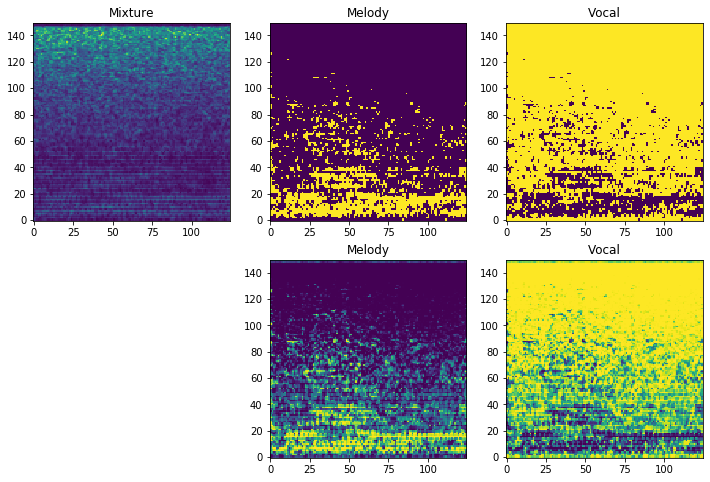

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from chimeranet.preprocessing import to_mixture, to_true_pair

x_train = to_mixture(specs_train)
y_train = to_true_pair(specs_train, noise=1e-16, mask='softmax') # if mask='binary', generate ibm

idx = 0
mixture = x_train[idx].transpose((1, 0))
mask_e = y_train['embedding'][idx].transpose((2, 1, 0))
mask_m = y_train['mask'][idx].transpose((2, 1, 0))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(2, 3, 1)
ax.title.set_text('Mixture')
ax.imshow(mixture, origin='lower', aspect='auto')
for i, (mask, name) in enumerate(zip(mask_e, ('Melody', 'Vocal')), 1):
    ax = fig.add_subplot(2, 3, 1+i)
    ax.title.set_text(name)
    ax.imshow(mask, origin='lower', aspect='auto', vmin=0, vmax=1)
for i, (mask, name) in enumerate(zip(mask_m, ('Melody', 'Vocal')), 1):
    ax = fig.add_subplot(2, 3, 4+i)
    ax.title.set_text(name)
    ax.imshow(mask, origin='lower', aspect='auto', vmin=0, vmax=1)

### Validation data

Like training data, validation data can be made in almost same way.

In [4]:
am_val = AudioMixer()
am_val.add_loader(DSD100MelodyLoader(dsd_path, dev=False, test=True))\
    .add_loader(DSD100VocalLoader(dsd_path, dev=False, test=True))
am_val.time(time).n_mels(n_mels).sr(sr).n_fft(n_fft).hop_length(hop_length)
am_val.sync_flag(True)

specs_validation = am_val.make_specs(sample_size, n_jobs=4)

### Saving

In [5]:
import h5py

with h5py.File('example-dataset.hdf5', 'w') as f:
    f.create_dataset('specs_train', data=specs_train)
    f.create_dataset('specs_validation', data=specs_validation)

[1] A. Liutkus et al., “The 2016 Signal Separation Evaluation Campaign,” in Latent Variable Analysis and Signal Separation - 12th International Conference, {LVA/ICA} 2015, Liberec, Czech Republic, August 25-28, 2015, Proceedings, 2017, pp. 323–332.